In [2]:
!pip install "numpy<2" --force-reinstall

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


In [3]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install prophet xgboost pandas numpy matplotlib seaborn scikit-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from math import sqrt


available_styles = plt.style.available
if 'seaborn-v0_8-darkgrid' in available_styles:
    plt.style.use('seaborn-v0_8-darkgrid')
elif 'ggplot' in available_styles:
    plt.style.use('ggplot')
elif 'fivethirtyeight' in available_styles:
    plt.style.use('fivethirtyeight')
else:
    print('Using default matplotlib style')
    

try:
    sns.set_palette("husl")
except:
    pass

print('Libraries loaded successfully!')

Libraries loaded successfully!


## Load and Explore Data

In [5]:

train_data = pd.read_csv('../Downloads/pastry-prediction/train.csv')
test_data = pd.read_csv('../Downloads/pastry-prediction/test.csv')
sample_submission = pd.read_csv('../Downloads/pastry-prediction/sample_submission.csv')

print(f'Train shape: {train_data.shape}')
print(f'Test shape: {test_data.shape}')
print(f'Submission shape: {sample_submission.shape}')
print('\nTrain columns:', train_data.columns.tolist())

display(train_data.head())

display(train_data.describe())

display(train_data.dtypes)

print('\nMissing values in train:')
print(train_data.isnull().sum())

Train shape: (5142, 13)
Test shape: (1575, 11)
Submission shape: (1575, 4)

Train columns: ['date', 'store', 'is_state_holiday', 'is_school_holiday', 'is_special_day', 'temperature_max', 'temperature_min', 'temperature_mean', 'sunshine_sum', 'precipitation_sum', 'sales', 'unsold', 'ordered']


,date,store,is_state_holiday,is_school_holiday,is_special_day,temperature_max,temperature_min,temperature_mean,sunshine_sum,precipitation_sum,sales,unsold,ordered
0,2021-08-02,store_5,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,1.432748,NaN,NaN
1,2021-08-02,store_8,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,1.253193,NaN,NaN
2,2021-08-02,store_7,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,0.985026,NaN,NaN
3,2021-08-02,store_4,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,0.889419,NaN,NaN
4,2021-08-02,store_1,normal_day,school_holiday,normal_day,21.8,16.3,19.590909,203,0.0,0.572282,NaN,NaN


,temperature_max,temperature_min,temperature_mean,sunshine_sum,precipitation_sum,sales,unsold,ordered
count,5142.000000,5142.000000,5142.000000,5142.000000,5142.000000,5142.000000,3226.000000,3226.000000
mean,15.601420,10.825729,13.641699,179.550758,0.916725,0.115530,0.047613,0.092610
std,8.317952,6.946531,7.825537,162.651716,2.596219,0.997744,0.994486,0.967469
min,-4.400000,-8.100000,-5.654545,0.000000,0.000000,-1.656999,-1.289811,-1.715776
25%,8.900000,5.800000,7.581818,11.000000,0.000000,-0.582000,-0.675520,-0.594898
50%,16.000000,10.950000,13.827273,148.000000,0.000000,0.045276,-0.146548,0.009850
75%,21.900000,16.200000,19.754545,308.000000,0.400000,0.712195,0.570125,0.672079
max,37.700000,30.200000,35.172727,551.000000,32.200000,7.539953,7.472362,7.869175


date                  object
store                 object
is_state_holiday      object
is_school_holiday     object
is_special_day        object
temperature_max      float64
temperature_min      float64
temperature_mean     float64
sunshine_sum           int64
precipitation_sum    float64
sales                float64
unsold               float64
ordered              float64
dtype: object


Missing values in train:
date                    0
store                   0
is_state_holiday        0
is_school_holiday       0
is_special_day          0
temperature_max         0
temperature_min         0
temperature_mean        0
sunshine_sum            0
precipitation_sum       0
sales                   0
unsold               1916
ordered              1916
dtype: int64


## Data Preprocessing

In [6]:
date_col = 'date'  
target_col = 'sales' 
store_col = 'store'

train_data[date_col] = pd.to_datetime(train_data[date_col])
test_data[date_col] = pd.to_datetime(test_data[date_col])

train_data = train_data.sort_values(date_col)
test_data = test_data.sort_values(date_col)

print(f'Date range in train: {train_data[date_col].min()} to {train_data[date_col].max()}')
print(f'Date range in test: {test_data[date_col].min()} to {test_data[date_col].max()}')

Date range in train: 2021-08-02 00:00:00 to 2023-11-30 00:00:00
Date range in test: 2023-12-01 00:00:00 to 2024-05-31 00:00:00


In [10]:

def handle_missing_values(df):

    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)
    
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if df[col].isnull().any():
            df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown', inplace=True)
    
    return df

train_data = handle_missing_values(train_data)
test_data = handle_missing_values(test_data)

print('Missing values handled successfully!')

Missing values handled successfully!


## Feature Engineering

In [7]:
def create_time_features(df, date_col):
    
    # Extract time components
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['dayofweek'] = df[date_col].dt.dayofweek
    df['week'] = df[date_col].dt.isocalendar().week.astype(int)
    df['quarter'] = df[date_col].dt.quarter
    df['dayofyear'] = df[date_col].dt.dayofyear
    
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_month_start'] = (df['day'] <= 3).astype(int)
    df['is_month_end'] = (df['day'] >= 28).astype(int)
    
    return df

train_data = create_time_features(train_data, date_col)
test_data = create_time_features(test_data, date_col)

print('Time features created:')
print(train_data.columns.tolist())

Time features created:
['date', 'store', 'is_state_holiday', 'is_school_holiday', 'is_special_day', 'temperature_max', 'temperature_min', 'temperature_mean', 'sunshine_sum', 'precipitation_sum', 'sales', 'unsold', 'ordered', 'year', 'month', 'day', 'dayofweek', 'week', 'quarter', 'dayofyear', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'is_weekend', 'is_month_start', 'is_month_end']


In [8]:
categorical_cols = train_data.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != date_col]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    
    combined_values = pd.concat([train_data[col], test_data[col]]).unique()
    le.fit(combined_values)
    
    train_data[col + '_encoded'] = le.transform(train_data[col])
    test_data[col + '_encoded'] = le.transform(test_data[col])
    
    label_encoders[col] = le

print(f'Encoded {len(categorical_cols)} categorical columns')

Encoded 4 categorical columns


## EDA

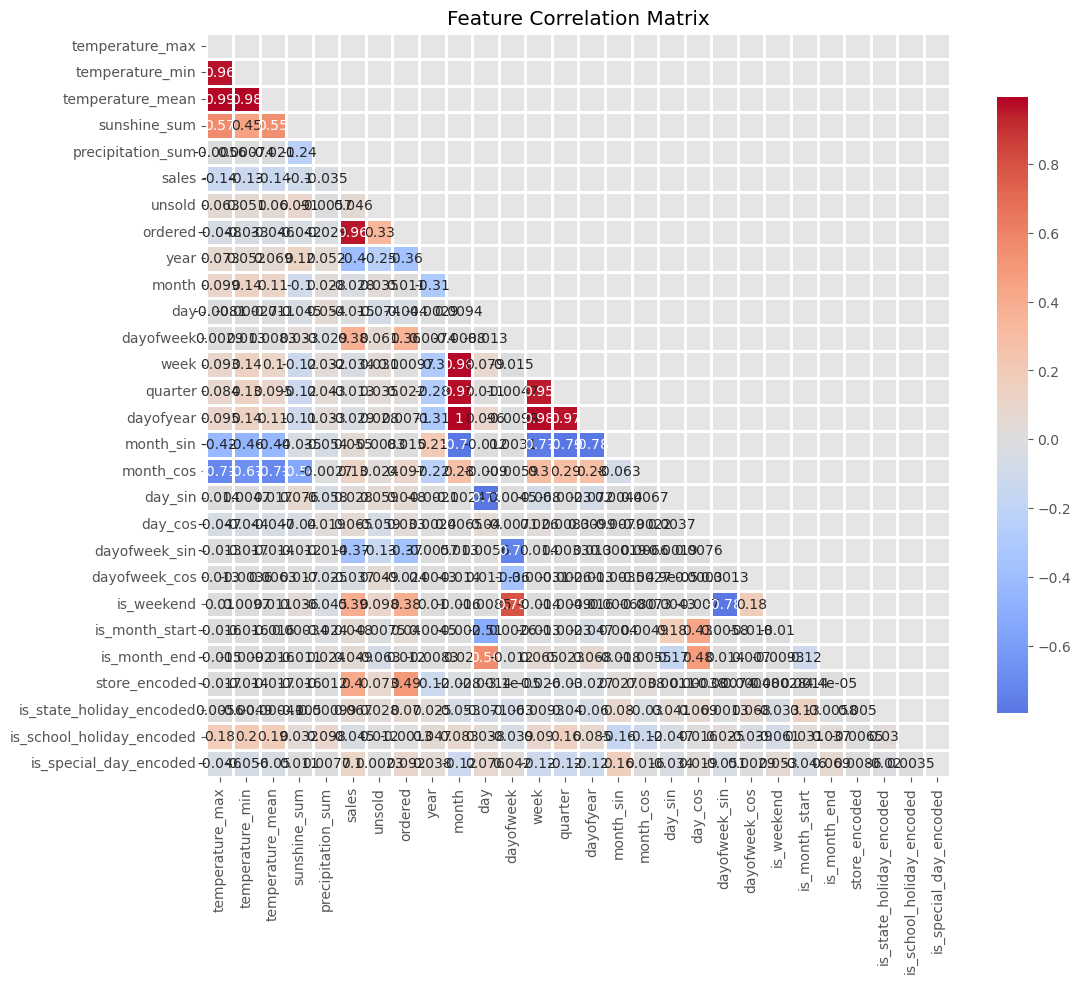


Top features correlated with sales:
sales                       1.000000
ordered                     0.957553
store_encoded               0.401847
is_weekend                  0.389463
dayofweek                   0.378916
month_cos                   0.126856
is_special_day_encoded      0.100762
is_state_holiday_encoded    0.066896
day_cos                     0.065316
month_sin                   0.054852
Name: sales, dtype: float64


In [11]:
numeric_cols = train_data.select_dtypes(include=[np.number]).columns
correlation_matrix = train_data[numeric_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.show()

target_corr = correlation_matrix[target_col].sort_values(ascending=False)
print(f'\nTop features correlated with {target_col}:')
print(target_corr.head(10))

## 6. Prophet Model Training

In [14]:
prophet_train = pd.DataFrame()
prophet_train['ds'] = train_data[date_col]
prophet_train['y'] = train_data[target_col]

regressors = []
potential_regressors = ['is_weekend', 'dayofweek', 'month_cos']
for reg in potential_regressors:
    if reg in train_data.columns and reg in test_data.columns:
        prophet_train[reg] = train_data[reg]
        regressors.append(reg)

print(f"Using regressors: {regressors}")

prophet_model = Prophet(
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    changepoint_range=0.9,
    interval_width=0.95
)


for reg in regressors:
    prophet_model.add_regressor(reg)


prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)


print('Training Prophet model...')
prophet_model.fit(prophet_train)


future = prophet_model.make_future_dataframe(periods=len(test_data), freq='D')

for reg in regressors:
    if reg in test_data.columns:
        combined_reg = pd.concat([
            train_data[reg].reset_index(drop=True),
            test_data[reg].reset_index(drop=True)
        ])
        future[reg] = combined_reg.values[:len(future)]
        future[reg].fillna(future[reg].median(), inplace=True)
    else:
        future[reg] = 0

08:25:27 - cmdstanpy - INFO - Chain [1] start processing


Using regressors: ['is_weekend', 'dayofweek', 'month_cos']
Training Prophet model...


08:25:28 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
prophet_forecast = prophet_model.predict(future)
print('Prophet predictions complete!')

test_start_idx = len(train_data)
prophet_test_predictions = prophet_forecast.iloc[test_start_idx:]['yhat'].values

Prophet predictions complete!


In [19]:
print('Forecast columns:', prophet_forecast.columns.tolist())
print('\nForecast summary:')
print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Forecast columns: ['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'daily', 'daily_lower', 'daily_upper', 'dayofweek', 'dayofweek_lower', 'dayofweek_upper', 'extra_regressors_multiplicative', 'extra_regressors_multiplicative_lower', 'extra_regressors_multiplicative_upper', 'is_weekend', 'is_weekend_lower', 'is_weekend_upper', 'month_cos', 'month_cos_lower', 'month_cos_upper', 'monthly', 'monthly_lower', 'monthly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'yhat']

Forecast summary:
             ds      yhat  yhat_lower  yhat_upper
2417 2028-03-19  1.023203  -36.584683   39.166191
2418 2028-03-20  0.322617  -11.648510   12.419785
2419 2028-03-21 -0.038026   -2.215298    1.922181
2420 2028-03-22 -0.047714   -2.339229    2.410695
2421 2028-03-23 -0.079515   -3.448393    3.174345


## XGBoost Model Training

In [21]:
common_cols = set(train_data.columns) & set(test_data.columns)
feature_cols = [
    col for col in common_cols
    if col not in [target_col, date_col, 'store', 'is_state_holiday', 'is_school_holiday', 'is_special_day']
    and train_data[col].dtype in ['int64', 'float64', 'int32', 'float32']
]

print(f"Using {len(feature_cols)} features for XGBoost")

X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]

print(f'Training features shape: {X_train.shape}')
print(f'Test features shape: {X_test.shape}')
print(f'\nFeatures used: {feature_cols}')

Using 25 features for XGBoost
Training features shape: (5142, 25)
Test features shape: (1575, 25)

Features used: ['month_sin', 'month', 'is_school_holiday_encoded', 'is_month_end', 'is_special_day_encoded', 'day', 'month_cos', 'sunshine_sum', 'day_cos', 'store_encoded', 'temperature_min', 'quarter', 'precipitation_sum', 'is_month_start', 'week', 'dayofweek', 'dayofweek_cos', 'year', 'day_sin', 'dayofyear', 'is_weekend', 'temperature_max', 'is_state_holiday_encoded', 'temperature_mean', 'dayofweek_sin']


In [22]:
split_date = train_data[date_col].quantile(0.8)
train_idx = train_data[date_col] < split_date
val_idx = train_data[date_col] >= split_date

X_tr = X_train[train_idx]
y_tr = y_train[train_idx]
X_val = X_train[val_idx]
y_val = y_train[val_idx]

print(f'Training set size: {len(X_tr)}')
print(f'Validation set size: {len(X_val)}')

Training set size: 4106
Validation set size: 1036


In [23]:
param_grid = {
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

tscv = TimeSeriesSplit(n_splits=3)

print('Performing grid search for XGBoost...')
grid_search = GridSearchCV(
    xgb_model, 
    param_grid, 
    cv=tscv, 
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_tr, y_tr)

best_xgb = grid_search.best_estimator_
print(f'\nBest parameters: {grid_search.best_params_}')
print(f'Best CV score: {-grid_search.best_score_:.4f}')

Performing grid search for XGBoost...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best CV score: 0.7336


Validation RMSE: 0.3560
Validation MAE: 0.2747


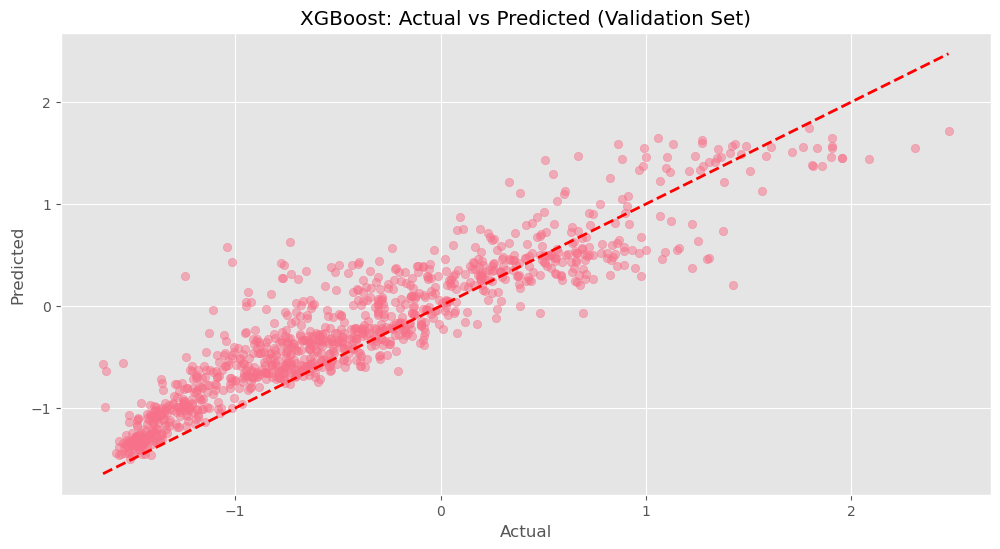

In [26]:
y_pred_val = best_xgb.predict(X_val)

from math import sqrt

rmse = sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)

def calculate_rmspe(y_true, y_pred):
    mask = y_true != 0
    return np.sqrt(np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2))

#rmspe = calculate_rmspe(y_val.values, y_pred_val)

print(f'Validation RMSE: {rmse:.4f}')
print(f'Validation MAE: {mae:.4f}')
#print(f'Validation RMSPE: {rmspe:.4f}')


plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost: Actual vs Predicted (Validation Set)')
plt.show()

In [38]:
train_data[target_col].describe()

count    5142.000000
mean        0.115530
std         0.997744
min        -1.656999
25%        -0.582000
50%         0.045276
75%         0.712195
max         7.539953
Name: sales, dtype: float64

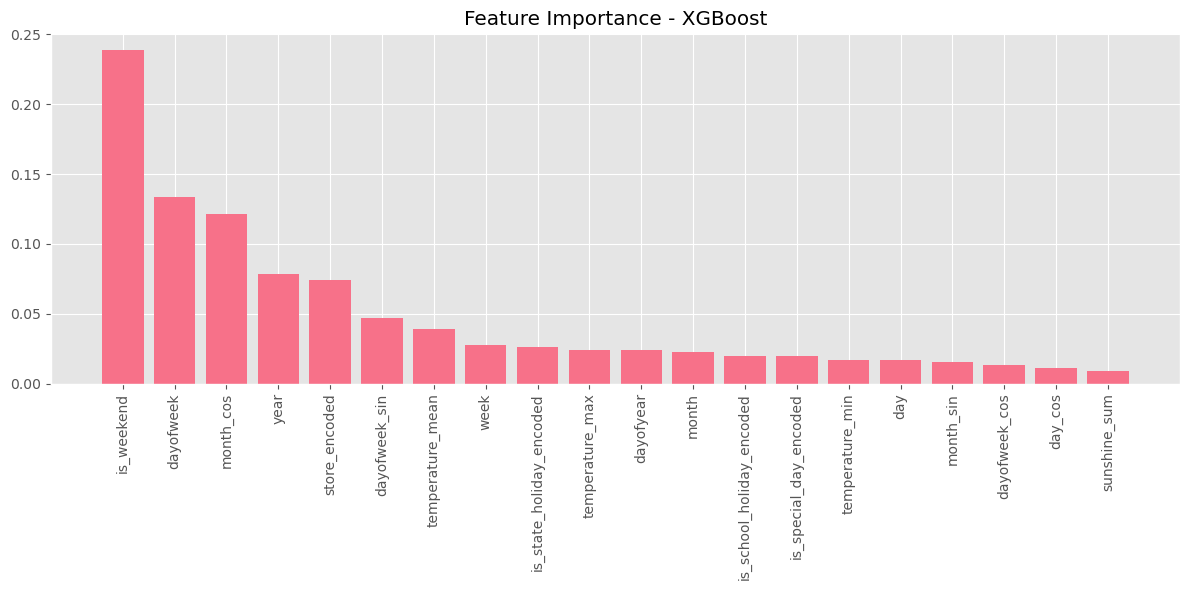

Top 10 most important features:
is_weekend: 0.2389
dayofweek: 0.1336
month_cos: 0.1212
year: 0.0788
store_encoded: 0.0743
dayofweek_sin: 0.0469
temperature_mean: 0.0393
week: 0.0279
is_state_holiday_encoded: 0.0260
temperature_max: 0.0238


In [25]:
importance = best_xgb.feature_importances_
indices = np.argsort(importance)[::-1][:20]  

plt.figure(figsize=(12, 6))
plt.title('Feature Importance - XGBoost')
plt.bar(range(len(indices)), importance[indices])
plt.xticks(range(len(indices)), [feature_cols[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

print('Top 10 most important features:')
for i in indices[:10]:
    print(f'{feature_cols[i]}: {importance[i]:.4f}')